### Event Data Processing Script

This script processes a JSON Lines file containing event data related to user activities on a web platform. It is designed to read the data, preprocess it for further analysis, and identify user sessions based on activity timestamps.

In [1]:
import pandas as pd
from datetime import datetime, timedelta

# Constant
INPUT_FILE = 'events.json'
SESSION_TIMEOUT = timedelta(minutes=30) # Define a session timeout threshold (30 minutes)

# Load the JSON Lines file
df = pd.read_json(INPUT_FILE, lines=True)

# Expand the 'event' dictionary into separate columns, rename 'customer-id', and remove unnecessary events
df = df.join(df.pop('event').apply(pd.Series)).rename(columns={'customer-id': 'customer_id'})
df = df[df['customer_id'].notnull()]

# Convert timestamp strings to datetime objects and sort by customer_id and timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['customer_id', 'timestamp'], inplace=True)

# Function to determine if a new session starts
def new_session(group):
    group['session_id'] = (group['timestamp'].diff() > SESSION_TIMEOUT).cumsum()
    return group

# Apply function to determine sessions
df_raw = df.groupby('customer_id').apply(new_session).reset_index(drop=True)

df_raw.head()

,id,type,user-agent,ip,customer_id,timestamp,page,product,query,referrer,position,session_id
0,77676,placed_order,Mozilla/5.0 (Android 4.2.2; Mobile; rv:67.0) G...,66.171.22.224,2.0,2022-05-19 16:55:18.648681,NaN,NaN,NaN,NaN,NaN,0
1,77675,page_view,Mozilla/5.0 (Android 4.2.2; Mobile; rv:67.0) G...,66.171.22.224,2.0,2022-05-19 16:55:18.648681,https://xcc-webshop.com/checkout,NaN,NaN,NaN,NaN,0
2,277302,page_view,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,143.233.186.22,2.0,2022-05-24 22:21:48.648681,https://xcc-webshop.com/checkout,NaN,NaN,NaN,NaN,1
3,277303,placed_order,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,143.233.186.22,2.0,2022-05-24 22:21:48.648681,NaN,NaN,NaN,NaN,NaN,1
4,494249,placed_order,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1 like M...,182.42.226.151,2.0,2022-05-25 06:48:48.648681,NaN,NaN,NaN,NaN,NaN,2


### Event DataFrame Cration

After loading the information, only necessary columns are maintained and also is new column called "unique_session_id" that is going be necessary to control each session according to the customer logged

In [2]:
# Copy the DataFrame to retain raw data for additional operations
event_info = df_raw.copy()

# Convert 'session_id' to string and concatenate it with 'customer_id' to create a unique session identifier
event_info['global_session_id'] = event_info['customer_id'].astype(str) + '_' + event_info['session_id'].astype(str)

# Create a mapping of these 'global_session_id' to a new unique identifier
unique_session_map = {sid: i for i, sid in enumerate(event_info['global_session_id'].unique(), start=1)}

# Map the global session ids to the new unique identifier
event_info['unique_session_id'] = event_info['global_session_id'].map(unique_session_map)

# Rename columns more efficiently
event_info.rename(columns={
    'id': 'event_id',
    'user-agent': 'user_agent',
    'session_id': 'customer_session',  # Renaming to clarify this as different from 'unique_session_id'
    'unique_session_id': 'session_id'  # Making this the new 'session_id'
}, inplace=True)

# Specify new order of columns, and include necessary adjustments for any columns you specifically need
new_order = ['event_id', 'customer_id', 'type', 'timestamp', 'page', 'customer_session', 'session_id']

# Reorder the columns based on new_order
event_info = event_info[new_order]

# Display the first few rows of the processed dataset
event_info.head()

,event_id,customer_id,type,timestamp,page,customer_session,session_id
0,77676,2.0,placed_order,2022-05-19 16:55:18.648681,NaN,0,1
1,77675,2.0,page_view,2022-05-19 16:55:18.648681,https://xcc-webshop.com/checkout,0,1
2,277302,2.0,page_view,2022-05-24 22:21:48.648681,https://xcc-webshop.com/checkout,1,2
3,277303,2.0,placed_order,2022-05-24 22:21:48.648681,NaN,1,2
4,494249,2.0,placed_order,2022-05-25 06:48:48.648681,NaN,2,3


### Session DataFrame Creation

After creating the Table Events, the next step is to create the Sessions Table, where is going be store the information about each seassion and the time of duration

In [3]:
# Group data by 'session_id' and aggregate information
session_info = event_info.groupby('session_id').agg(
    customer_id=('customer_id', 'first'),  # Fetch the first 'customer_id' in each session
    session_start=('timestamp', 'min'), # Minimum timestamp for the start of the session
    session_end=('timestamp', 'max'), # Maximum timestamp for the end of the session
    num_events=('event_id', 'count') # Count of events per session
).reset_index()

# Calculate the duration of each session in minutes
session_info['session_duration'] = (session_info['session_end'] - session_info['session_start']).dt.total_seconds() / 60

# Display the first few rows of the session information
session_info.head()

,session_id,customer_id,session_start,session_end,num_events,session_duration
0,1,2.0,2022-05-19 16:55:18.648681,2022-05-19 16:55:18.648681,2,0.00
1,2,2.0,2022-05-24 22:21:48.648681,2022-05-24 22:21:48.648681,2,0.00
2,3,2.0,2022-05-25 06:48:48.648681,2022-05-25 06:48:48.648681,2,0.00
3,4,2.0,2022-05-25 09:14:33.648681,2022-05-25 09:14:33.648681,2,0.00
4,5,3.0,2022-05-15 14:18:33.648681,2022-05-15 14:58:18.648681,7,39.75


### CSV Saving
Saving the files as CSV for backup

In [4]:
# Save the event information to a CSV file
event_info.to_csv('events.csv', index=False, header=True)

# Save the session information to a CSV file
session_info.to_csv('sessions.csv', index=False, header=True)

### SQL Code 
Connection with SQL Database to create the tables and also insert the data from the dataframes

In [5]:
import psycopg2
from psycopg2.extras import execute_values
from sqlalchemy import create_engine

# Database connection parameters
database_name = 'webshop'
user_name = 'postgres'
user_password = input("DataBase Password")
host_address = 'localhost'

# Connect to the database
connection = psycopg2.connect(dbname=database_name, user=user_name, password=user_password, host=host_address)
cursor = connection.cursor()

# SQLAlchemy engine for pandas
engine = create_engine(f'postgresql+psycopg2://{user_name}:{user_password}@{host_address}/{database_name}')

# SQL for creating tables
sessions_table_sql = '''
DROP TABLE IF EXISTS sessions;
CREATE TABLE sessions (
    session_id SERIAL PRIMARY KEY,
    customer_id INTEGER,
    session_start TIMESTAMP,
    session_end TIMESTAMP,
    num_events INTEGER,
    session_duration DECIMAL
);
'''

events_table_sql = '''
DROP TABLE IF EXISTS events;
CREATE TABLE events (
    event_id SERIAL PRIMARY KEY,
    customer_id INTEGER,
    type TEXT,
    timestamp TIMESTAMP,
    page TEXT,
    customer_session INTEGER,
    session_id INTEGER REFERENCES sessions(session_id)
);
'''

# Execute SQL statements to create tables
cursor.execute(sessions_table_sql)
cursor.execute(events_table_sql)


# Commit changes and close connections
connection.commit()
cursor.close()
connection.close()

In [6]:
# Loading the DataFrames to the SQL Table
event_info.to_sql('events', con=engine, index=False, if_exists='replace')
session_info.to_sql('sessions', con=engine, index=False, if_exists='replace')

807

### Creating SQL Table with important metrics analyzed 

In [8]:
# Connect to the database
connection = psycopg2.connect(dbname=database_name, user=user_name, password=user_password, host=host_address)
cursor = connection.cursor()

# Create tables
cursor.execute('''
DROP TABLE IF EXISTS DurationFirstPurchase;
CREATE TABLE DurationFirstPurchase AS
WITH FirstPurchase AS (
    SELECT
        customer_id,
        MIN(session_id) AS first_purchase_session_id
    FROM events
    WHERE type = 'placed_order'
    GROUP BY customer_id
),
DurationFirstPurchase AS (
    SELECT
        s.customer_id,
        SUM(s.session_duration) AS total_duration
    FROM
        sessions s
    INNER JOIN FirstPurchase fp ON s.customer_id = fp.customer_id
    WHERE
        s.session_id <= fp.first_purchase_session_id
    GROUP BY
        s.customer_id
)
SELECT
    *
FROM
    DurationFirstPurchase;
''')

cursor.execute('''
DROP TABLE IF EXISTS AmountSessions;
CREATE TABLE AmountSessions AS
WITH PurchaseSessions AS (
    SELECT
        customer_id,
        session_id,
        type,
        LAG(session_id, 1) OVER (PARTITION BY customer_id ORDER BY session_id) AS previous_session_id
    FROM events
    WHERE type = 'placed_order'
),
SessionCounts AS (
    SELECT
        customer_id,
        session_id,
        COALESCE(previous_session_id, 0) AS previous_session_id
    FROM PurchaseSessions
),
SessionCalculations AS (
    SELECT
        sc.customer_id,
        sc.session_id AS purchase_session_id,
        (
            SELECT COUNT(*)
            FROM sessions
            WHERE sessions.customer_id = sc.customer_id
            AND sessions.session_id <= sc.session_id
            AND (sessions.session_id > sc.previous_session_id OR sc.previous_session_id = 0)
        ) AS sessions_before_purchase
    FROM SessionCounts sc
)
SELECT
    *

FROM SessionCalculations;
''')

# Commit and close
connection.commit()
cursor.close()
connection.close()


## Run the API_Code.py to load the info

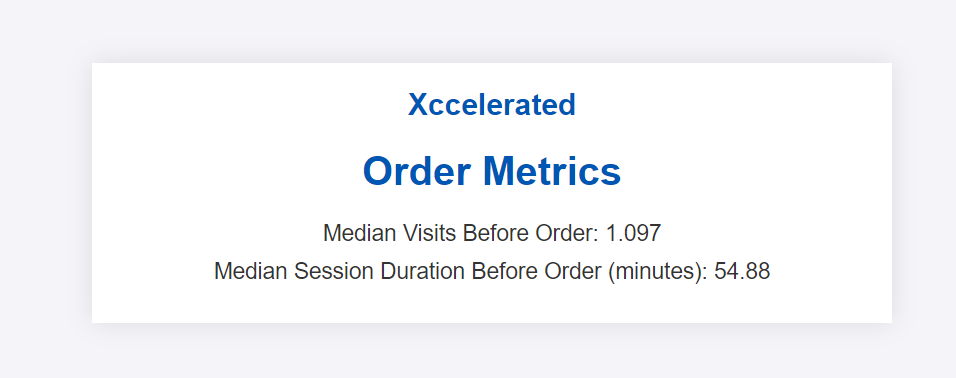